In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [18]:
df = pd.read_csv('fake_client_data_pt_30k_var_real_updated (1).csv')

In [19]:
df.head()

,IDCliente,Idade,Genero,RendaAnual,PontuacaoGasto,Regiao,TempoComoCliente,ComprasTotais,ValorMedioCompra,CategoriaPreferida,VisitasSite,AssinaturaEmail,AssinaturaTelefone,Devolucoes,PontuacaoAvaliacoes,DescontosUsados,Indicacao,DispositivoUsado,DataHoraPedido
0,1,18,Masculino,86914.334482,7,Norte,10,39.445494,158.520816,Acessórios,328.995983,0,0,37.795569,2.836743,8.845712,1,Tablet,2023-02-12 19:05:47.891596386
1,2,61,Masculino,43698.299404,51,Norte,5,63.827308,228.518462,Calçados,309.085373,0,0,12.265035,2.062234,22.784960,0,Mobile,2023-09-27 23:59:54.239807996
2,3,64,Masculino,59135.272756,19,Norte,16,19.917029,74.239716,Roupas,234.131622,1,0,30.503646,3.017242,23.135022,0,Desktop,2023-07-12 00:06:08.652288410
3,4,29,Masculino,71641.980942,19,Sul,17,74.305957,66.510289,Roupas,201.281146,0,0,9.428430,3.133959,19.330340,0,Mobile,2023-06-14 13:58:06.476215874
4,5,55,Feminino,67456.797967,75,Norte,2,22.768440,195.089137,Roupas,374.182370,1,0,16.796137,4.276833,8.072638,0,Mobile,2023-03-08 07:10:11.420380680


## Dicionários dos dados
- IDCliente:	Identificação única do cliente
- Idade: Idade do cliente
- Genero: Gênero do cliente
- RendaAnual: Renda anual do cliente
- PontuacaoGasto: Pontuação de gasto do cliente (1-100)
- Regiao:	Região de residência do cliente
- TempoComoCliente:	Tempo em anos como cliente
- UltimaCompra:	Dias desde a última compra
- ComprasTotais: Número total de compras
- ValorMedioCompra:	Valor médio das compras
- CategoriaPreferida: Categoria de produtos preferida do cliente
- VisitasSite: Número de visitas ao site
- AssinaturaEmail:	Cliente possui assinatura de email (0=Não, 1=Sim)
- AssinaturaTelefone: Cliente possui assinatura de telefone (0=Não, 1=Sim)
- Devolucoes:	Número de devoluções feitas pelo cliente
- PontuacaoAvaliacoes:	Pontuação média das avaliações dadas pelo cliente (1-5)
- DescontosUsados:	Número de descontos usados pelo cliente
- Indicacao	Cliente: indicou outros (0=Não, 1=Sim)
- DispositivoUsado:	Dispositivo preferido do cliente para acessar o site
- DataHoraPedido: Data e hora dos pedidos

In [19]:
def plot_perc(coluna, dados, title="Distribuição dos estados dos clientes", xlabel="Estado"):
    plt.figure(figsize=(20, 8))
    g = sns.countplot(x=coluna, data=dados, orient='h')
    g.set_title(title, fontsize=20)
    g.set_xlabel(xlabel, fontsize=17)
    g.set_ylabel("Contagem", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    
    total = sum(p.get_height() for p in g.patches)  # Soma total de todas as alturas das barras
    
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width() / 1.6,
               height + 200,
               '{:1.2f}%'.format(height / total * 100),  # Calcula a porcentagem com a soma total
               ha='center', va='bottom', fontsize=12)
    
    g.set_ylim(0, max(p.get_height() for p in g.patches) * 1.1)

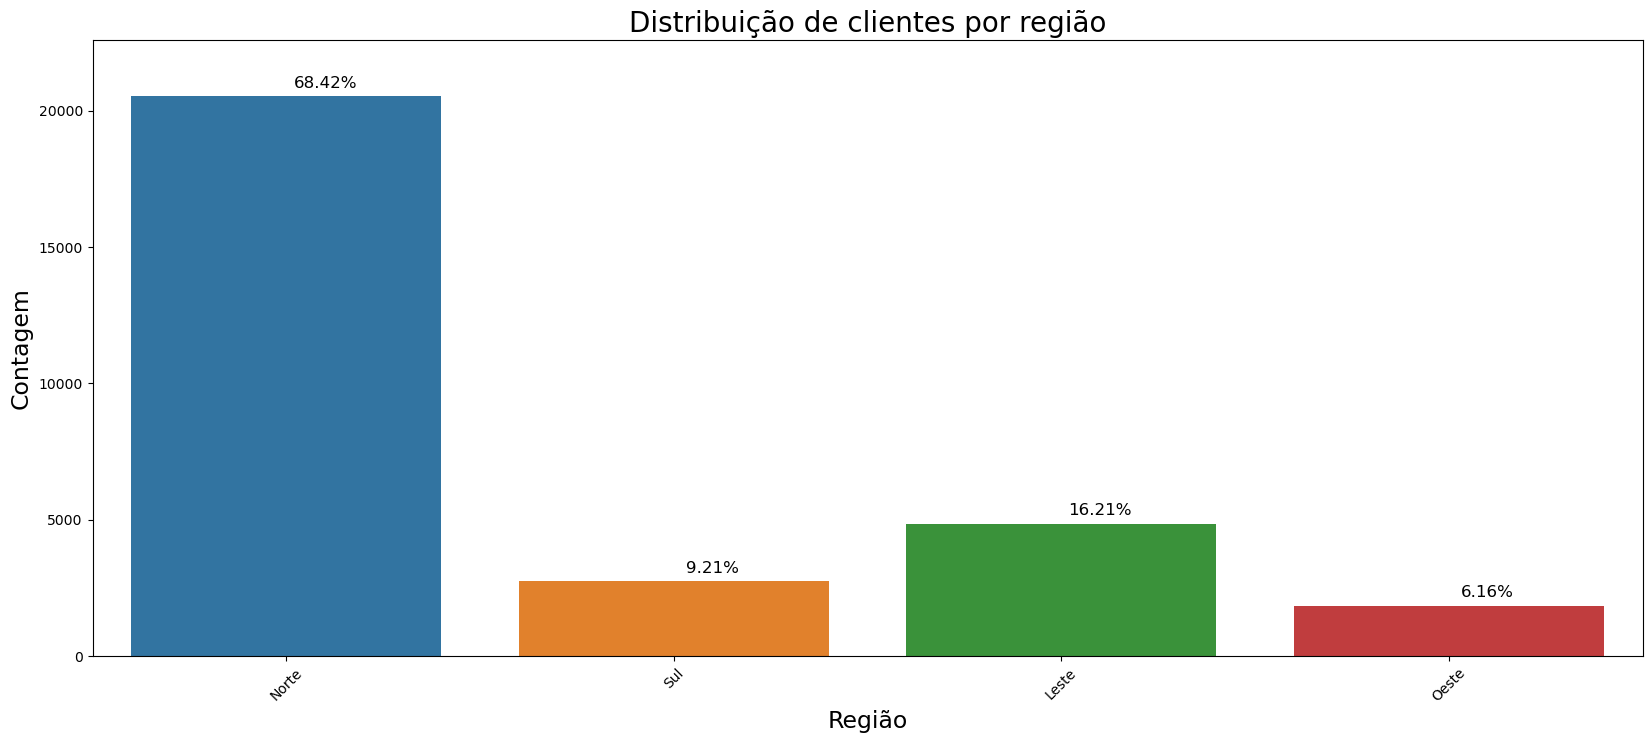

In [21]:
# Chamando a função com os parâmetros definidos
plot_perc('Regiao', df, title="Distribuição de clientes por região", xlabel="Região")
plt.show()

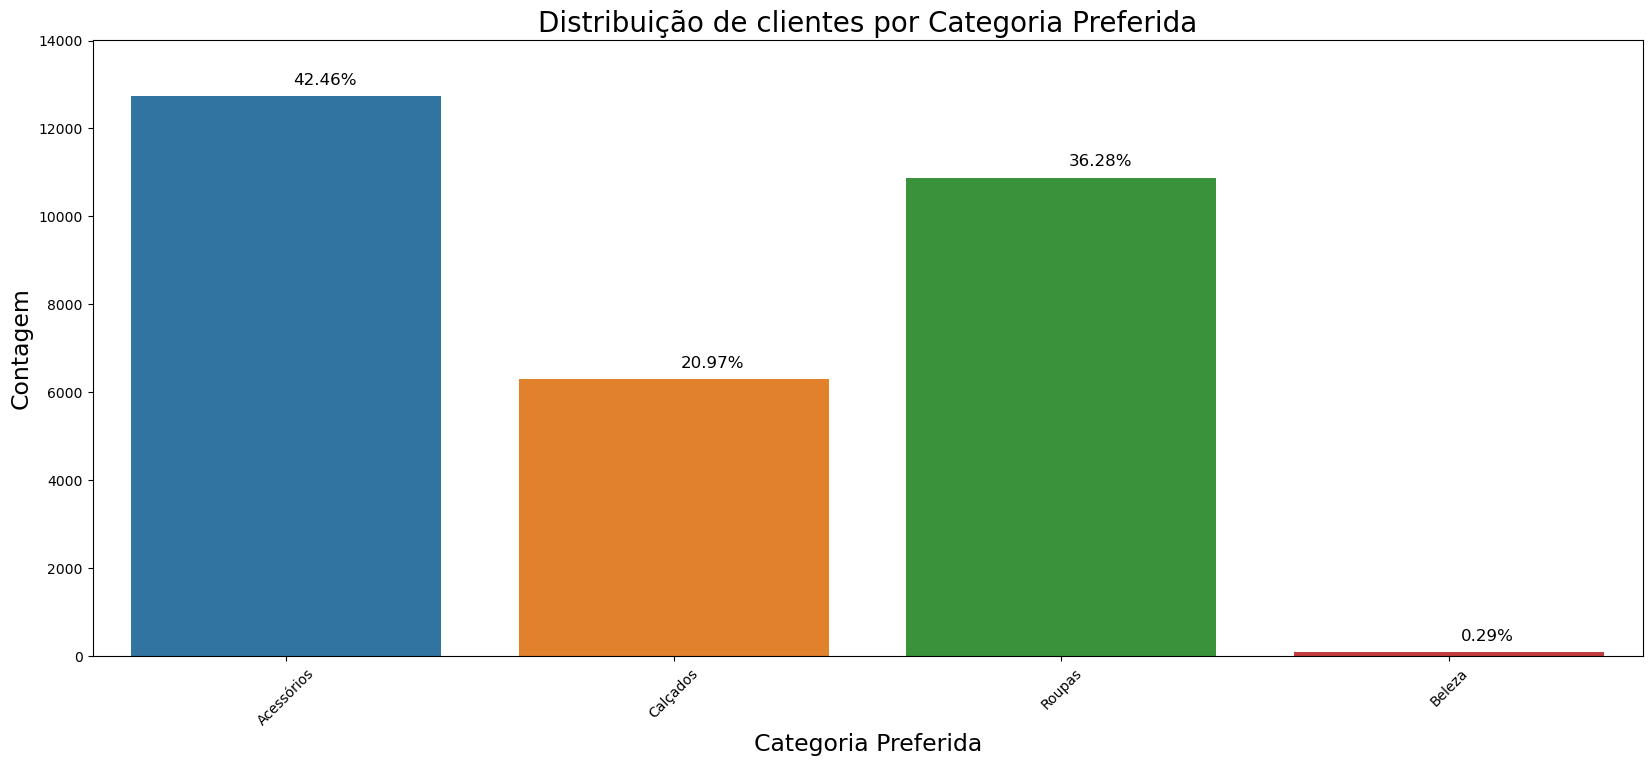

In [22]:
# Chamando a função com os parâmetros definidos
plot_perc('CategoriaPreferida', df, title="Distribuição de clientes por Categoria Preferida", xlabel="Categoria Preferida")
plt.show()

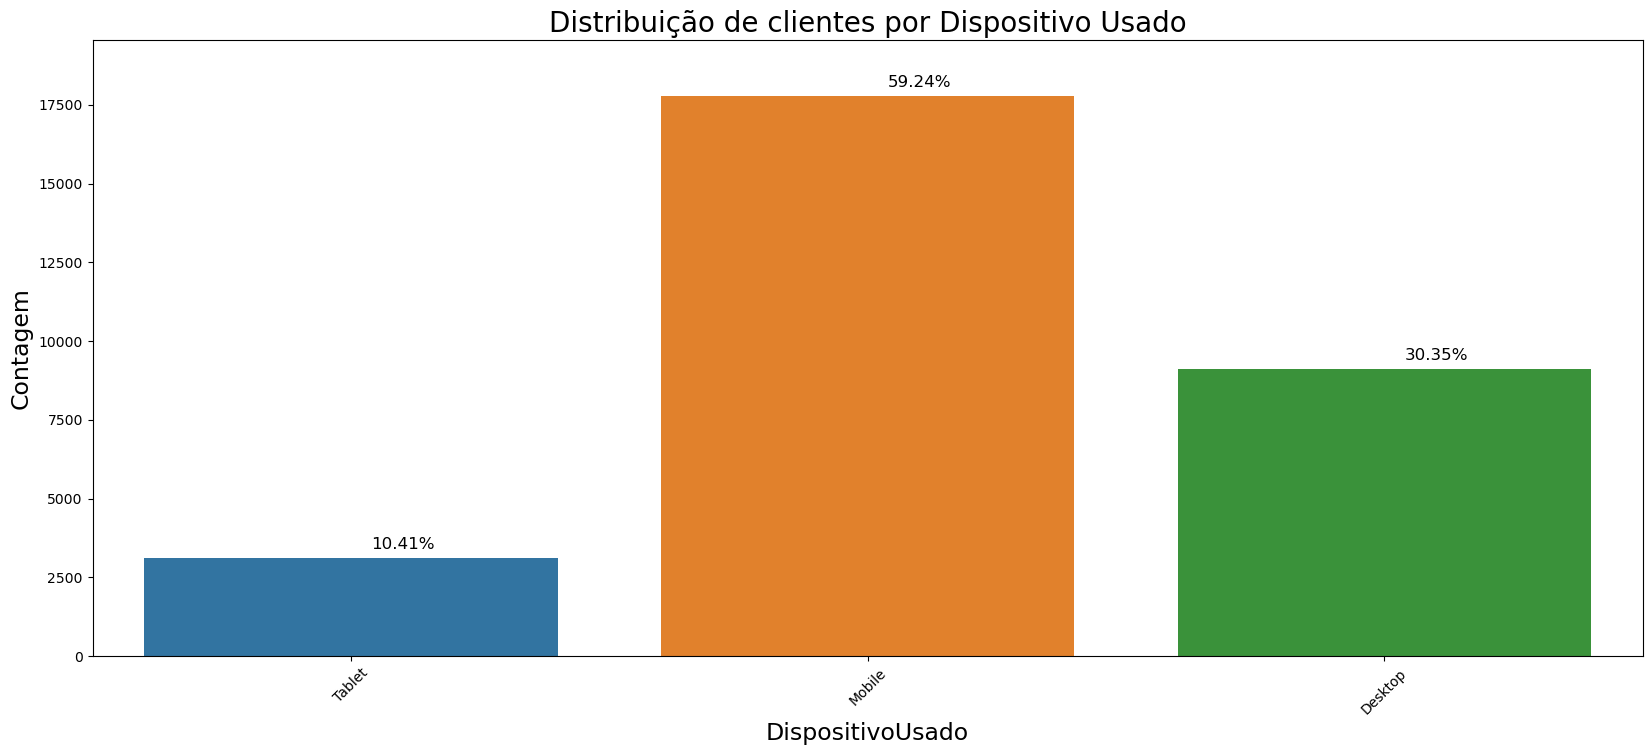

In [23]:
# Chamando a função com os parâmetros definidos
plot_perc('DispositivoUsado', df, title="Distribuição de clientes por Dispositivo Usado", xlabel="DispositivoUsado")
plt.show()

In [28]:
# Preparar os dados para análise RFM
# Recência: Número de dias desde a última compra
df['DataHoraPedido'] = pd.to_datetime(df['DataHoraPedido'])
current_date = df['DataHoraPedido'].max() + pd.DateOffset(days=1)
df['Recencia'] = (current_date - df['DataHoraPedido']).dt.days

# Frequência: Número de compras
freq_df = df.groupby('IDCliente').size().reset_index(name='Frequencia')

# Valor Monetário: Soma do valor gasto
monetary_df = df.groupby('IDCliente')['ValorMedioCompra'].sum().reset_index(name='ValorMonetario')

# Combinando as métricas RFM
rfm_df = df.groupby('IDCliente').agg({
    'Recencia': 'min',
}).reset_index()
rfm_df = rfm_df.merge(freq_df, on='IDCliente')
rfm_df = rfm_df.merge(monetary_df, on='IDCliente')

# Atribuir pontuações RFM usando quartis
rfm_df['R_quartil'] = pd.qcut(rfm_df['Recencia'], 4, labels=[4, 3, 2, 1])
rfm_df['F_quartil'] = pd.qcut(rfm_df['Frequencia'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm_df['M_quartil'] = pd.qcut(rfm_df['ValorMonetario'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# Combinar pontuações RFM
rfm_df['RFM_Score'] = rfm_df.R_quartil.astype(str) + rfm_df.F_quartil.astype(str) + rfm_df.M_quartil.astype(str)

# Definir percentis para a segmentação
def get_rfm_segment(rfm_score):
    if int(rfm_score) >= 433:
        return 'Clientes Premium'
    elif int(rfm_score) >= 322:
        return 'Clientes Frequentes'
    elif int(rfm_score) >= 211:
        return 'Clientes Promissores'
    elif int(rfm_score) >= 144:
        return 'Clientes Novatos'
    elif int(rfm_score) >= 111:
        return 'Clientes Em Risco'
    else:
        return 'Clientes Inativos'

# Aplicar a segmentação
rfm_df['Segmento'] = rfm_df['RFM_Score'].apply(get_rfm_segment)

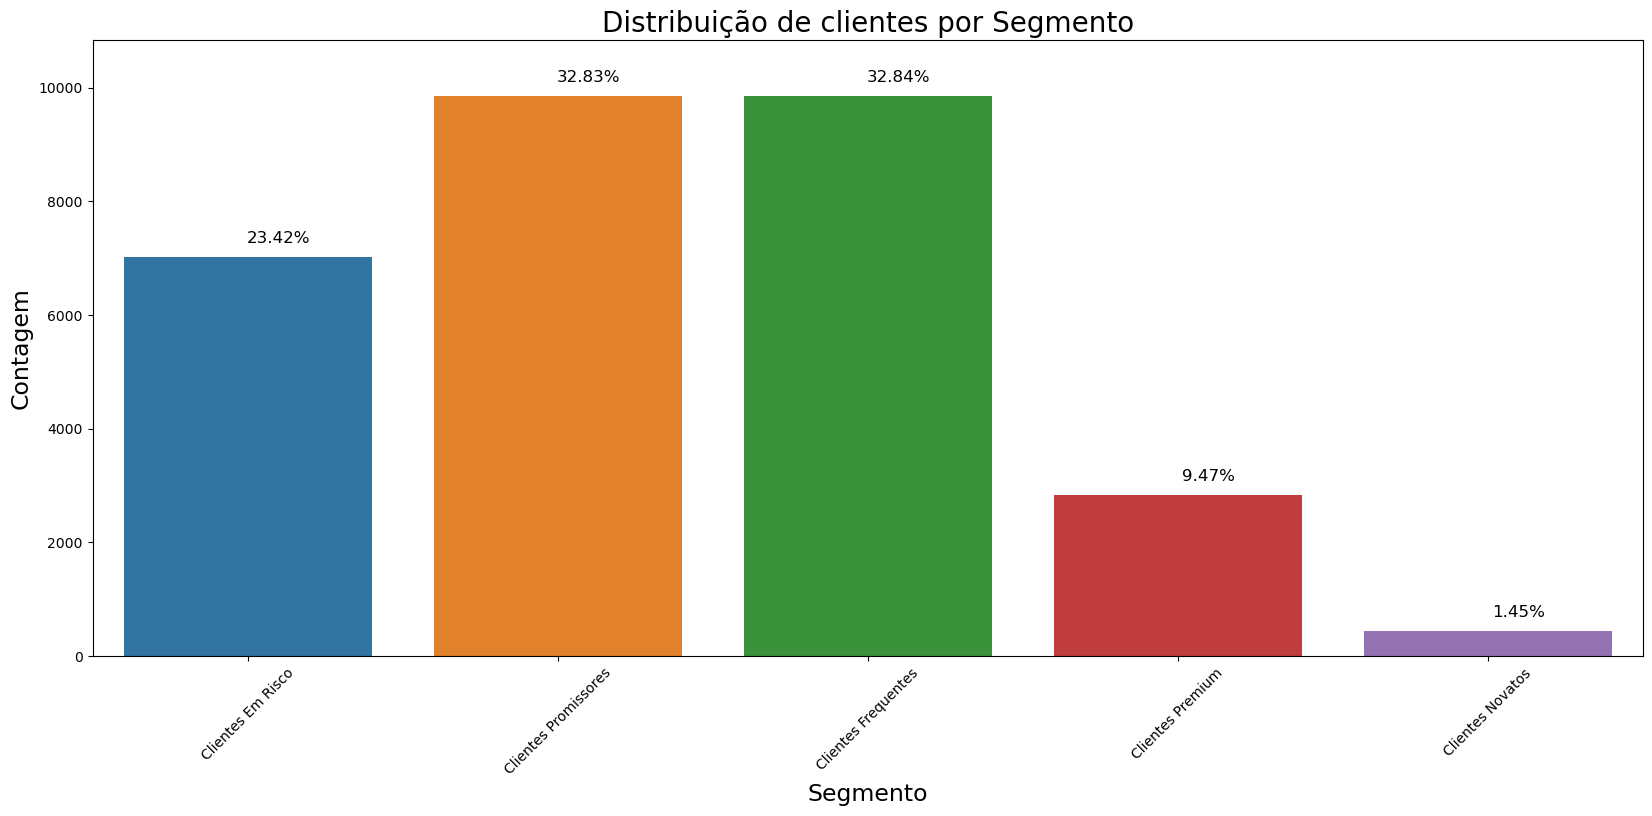

In [32]:
plot_perc('Segmento', rfm_df, title="Distribuição de clientes por Segmento", xlabel="Segmento")
plt.show()

## Regras de Segmentação RFM

### Clientes Premium (RFM_Score >= 433):

- Critérios: Alta recência, alta frequência e alto valor monetário.
- Estratégia: Oferecer vantagens exclusivas, programas de fidelidade, descontos especiais e acesso antecipado a novos produtos.

## Clientes Frequentes (322 <= RFM_Score < 433):

- Critérios: Frequência alta e valor monetário médio, com recência média.
- Estratégia: Manter o engajamento com ofertas regulares e recompensas por lealdade.

## Clientes Promissores (211 <= RFM_Score < 322):

- Critérios: Alta recência, mas frequência e valor monetário baixos.
- Estratégia: Incentivar compras adicionais com promoções, cupons e campanhas de remarketing.

## Clientes Novatos (144 <= RFM_Score < 211):

- Critérios: Alta recência, mas frequência e valor monetário variando entre médio e alto.
- Estratégia: Focar em manter o engajamento inicial com boas-vindas, descontos para próximas compras e excelente atendimento ao cliente.

## Clientes Em Risco (111 <= RFM_Score < 144):

- Critérios: Recência e frequência médias, mas valor monetário baixo.
- Estratégia: Evitar a perda desses clientes com ofertas especiais e personalizadas, além de verificar se houve algum problema com a experiência de compra.

## Clientes Inativos (RFM_Score < 111):

- Critérios: Baixa recência, baixa frequência e baixo valor monetário.
- Estratégia: Reativar esses clientes com campanhas de reengajamento, como e-mails de saudade, ofertas especiais e descontos agressivos.